In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import re
import pandas as pd
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy
import matplotlib.pyplot as plt
import numpy as np
import logging
import multiprocessing
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalMaxPool1D, MaxPooling1D, Flatten, concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

# Task description and Data loading

## Hanna's data

In [0]:
# import zipfile
# with zipfile.ZipFile('./drive/My Drive/hackaton/wili-2018.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

In [0]:
# data_path = '/content/drive/My Drive/Colab Notebooks/Hackathon/'
# wili_data_path = ''

# x_train_path = wili_data_path + 'x_train.txt'
# x_test_path = wili_data_path + 'x_test.txt'
# y_train_path = wili_data_path + 'y_train.txt'
# y_test_path = wili_data_path + 'y_test.txt'
# labels_path = wili_data_path + 'labels.csv'

## Download data

In [0]:
data_path = '/content/drive/My Drive/Colab Notebooks/Hackathon/'
wili_data_path = data_path + 'wili-2018/'

x_train_path = wili_data_path + 'x_train.txt'
x_test_path = wili_data_path + 'x_test.txt'
y_train_path = wili_data_path + 'y_train.txt'
y_test_path = wili_data_path + 'y_test.txt'
labels_path = wili_data_path + 'labels.csv'

In [7]:
labels = pd.read_csv(labels_path, sep=';')
labels = labels.drop(labels=['German', 'Writing system', 'Remarks', 'Synonyms'], axis=1)
labels

,Label,English,Wiki Code,ISO 369-3,Language family
0,ace,Achinese,ace,ace,Austronesian
1,afr,Afrikaans,af,afr,Indo-European
2,als,Alemannic German,als,gsw,Indo-European
3,amh,Amharic,am,amh,Afro-Asiatic
4,ang,Old English,ang,ang,Indo-European
...,...,...,...,...,...
230,yid,Yiddish,yi,yid,Indo-European
231,yor,Yoruba,yo,yor,Niger-Congo
232,zea,Zeeuws,zea,zea,Indo-European
233,zh-yue,Cantonese,zh-yue,NaN,Sino-Tibetan


In [0]:
class_to_language = labels.Label.astype(str).to_dict()
language_to_class = {v: k for k, v in class_to_language.items()}
num_classes = len(class_to_language)

In [9]:
print(list(language_to_class.items())[:5])
num_classes

[('ace', 0), ('afr', 1), ('als', 2), ('amh', 3), ('ang', 4)]


235

In [0]:
def read_data():
    with open(x_train_path) as f:
        mylist = f.read().splitlines() 
    x_train = pd.DataFrame(mylist, columns=["sent"])
    with open(x_test_path) as f:
        mylist = f.read().splitlines() 
    x_test = pd.DataFrame(mylist, columns=["sent"])

    with open(y_train_path) as f:
        mylist = f.read().splitlines() 
    y_train = []
    for lan in mylist:
        y_train.append(language_to_class[lan])
    y_train = pd.DataFrame(y_train)
    with open(y_test_path) as f:
        mylist = f.read().splitlines()

    y_test = []
    for lan in mylist:
        y_test.append(language_to_class[lan])
    y_test = pd.DataFrame(y_test)
    
    return (x_train, y_train), (x_test, y_test)

In [11]:
(x_train, y_train), (x_test, y_test) = read_data()

print(x_train.head())
print(y_train.head())

print(x_train.shape)
print(x_test.shape)

                                                sent
0  Klement Gottwaldi surnukeha palsameeriti ning ...
1  Sebes, Joseph; Pereira Thomas (1961) (på eng)....
2  भारतीय स्वातन्त्र्य आन्दोलन राष्ट्रीय एवम क्षे...
3  Après lo cort periòde d'establiment a Basilèa,...
4  ถนนเจริญกรุง (อักษรโรมัน: Thanon Charoen Krung...
     0
0   52
1  198
2  124
3  155
4  207
(117500, 1)
(117500, 1)


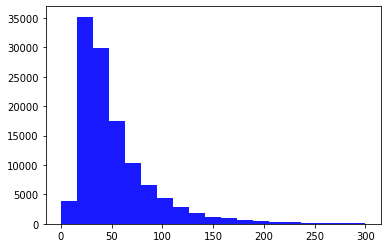

In [12]:
lens = x_train.sent.str.split(' ').str.len().values
plt.hist(lens, bins=np.linspace(0,300,20), facecolor='blue', alpha=0.9)
plt.show()

# Analysis of possible solutions

## Unicode-based

## Embeddings

In [0]:
filter_out = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n1234567890'
tokenizer = Tokenizer(filters=filter_out, lower=True)
tokenizer.fit_on_texts(x_train.sent)

In [14]:
# try different values of `count`
# show how many words are presenting more than `count` times
count = 10
frequent_words = [w for w,c in tokenizer.word_counts.items() if c > count]
len(frequent_words)

64157

In [0]:
def prepare_data(train_x, train_y, tokenizator, max_len_of_vector):
    x_tr, x_val, y_tr, y_val = train_test_split(train_x, train_y, test_size=0.1, random_state=1, stratify=train_y.values)
   
    tokenizator.fit_on_texts(x_tr.sent)

    train_X = tokenizator.texts_to_sequences(x_tr.sent)
    val_X = tokenizator.texts_to_sequences(x_val.sent)

    ## Pad the sentences 
    train_X = pad_sequences(train_X, maxlen=max_len_of_vector)
    val_X = pad_sequences(val_X, maxlen=max_len_of_vector)

    return (train_X, y_tr), (val_X, y_val)

In [0]:
embed_size = 300 # how big is each word vector
max_features = len(frequent_words) # how many unique words to use (i.e num rows in embedding vector)
maxlen = 200 # max number of words in a question to use

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features, filters=filter_out, lower=True)    

In [0]:
(train_X, train_Y), (val_X, val_Y) = prepare_data(x_train, y_train, tokenizer, maxlen)

In [18]:
lb = LabelEncoder()
y = lb.fit_transform(train_Y.values.ravel())
dummy_y_train = to_categorical(y)

print(len(dummy_y_train))
print(len(dummy_y_train[0]))

y = lb.fit_transform(val_Y.values.ravel())
dummy_y_val = to_categorical(y)

105750
235


# Neural Networks

## Metrics

In [0]:
def combined_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    false_positives = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)), axis=0)
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)), axis=0)
    false_negatives = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)), axis=0)
    precision = max(true_positives / (true_positives + false_positives  + K.epsilon()))
    recall = max(true_positives / (true_positives + false_negatives  + K.epsilon()))
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return precision, recall, f1

def recall(y_true, y_pred):
    _, recall, _ = combined_metric(y_true, y_pred)
    return recall

def precision(y_true, y_pred):
    precision, _, _ = combined_metric(y_true, y_pred)
    return precision

def f1(y_true, y_pred):
    _, _, f1 = combined_metric(y_true, y_pred)
    return f1

In [0]:
def combined_metric_train(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2*(precision*recall)/(precision+recall+K.epsilon())
    return precision, recall, f1

def recall_train(y_true, y_pred):
    _, recall, _ = combined_metric_train(y_true, y_pred)
    return recall

def precision_train(y_true, y_pred):
    precision, _, _ = combined_metric_train(y_true, y_pred)
    return precision

def f1_train(y_true, y_pred):
    _, _, f1 = combined_metric_train(y_true, y_pred)
    return f1

In [0]:
train_metrics = [tf.metrics.categorical_accuracy, precision_train, recall_train, f1_train]

## CNN

In [29]:
cnn_model = Sequential()
cnn_model.add(Embedding(max_features, embed_size, input_shape=(maxlen,)))
cnn_model.add(Conv1D(256, 5, activation='relu', input_shape=(embed_size,)))
cnn_model.add(MaxPooling1D(5))
cnn_model.add(Dropout(0.2))
cnn_model.add(Conv1D(256, 5, activation='relu'))
cnn_model.add(MaxPooling1D(5))
cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation="relu"))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(num_classes, activation='softmax'))
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 300)          19247100  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 196, 256)          384256    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 256)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 39, 256)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 35, 256)           327936    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 7, 256)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1792)             

In [0]:
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=train_metrics)

In [0]:
cnn_cp_path = data_path+'model_cnn.hdf5'
cnn_cp=ModelCheckpoint(cnn_cp_path, monitor='val_loss',save_best_only=True)

In [33]:
cnn_model.fit(train_X, dummy_y_train, batch_size=512, epochs=5, 
              validation_data=(val_X, dummy_y_val),
              callbacks = [cnn_cp])

Epoch 1/5
207/207 [==============================] - 60s 291ms/step - loss: 3.0122 - categorical_accuracy: 0.3563 - precision_train: 0.6566 - recall_train: 0.2696 - f1_train: 0.3346 - val_loss: 0.6418 - val_categorical_accuracy: 0.8580 - val_precision_train: 0.9593 - val_recall_train: 0.7942 - val_f1_train: 0.8689
Epoch 2/5
207/207 [==============================] - 59s 283ms/step - loss: 0.4511 - categorical_accuracy: 0.8894 - precision_train: 0.9601 - recall_train: 0.8551 - f1_train: 0.9044 - val_loss: 0.4626 - val_categorical_accuracy: 0.8954 - val_precision_train: 0.9672 - val_recall_train: 0.8672 - val_f1_train: 0.9144
Epoch 3/5
207/207 [==============================] - 57s 277ms/step - loss: 0.2254 - categorical_accuracy: 0.9374 - precision_train: 0.9806 - recall_train: 0.9215 - f1_train: 0.9501 - val_loss: 0.4983 - val_categorical_accuracy: 0.8920 - val_precision_train: 0.9540 - val_recall_train: 0.8755 - val_f1_train: 0.9130
Epoch 4/5
207/207 [==============================] -

In [0]:
dependencies = {
     'f1': f1_train,
     'recall': recall_train,
     'precision': precision_train
}

In [0]:
# cnn_model = load_model(cnn_cp_path, custom_objects=dependencies)

## RNN

In [35]:
rnn_model = Sequential()
rnn_model.add(Embedding(max_features, embed_size))
rnn_model.add(Bidirectional(LSTM(128, return_sequences=True, activation='tanh',input_dim=embed_size)))
rnn_model.add(Dropout(0.2))
rnn_model.add(Bidirectional(LSTM(128, return_sequences=True, activation='tanh')))
rnn_model.add(GlobalMaxPool1D())
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(512, activation="relu"))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(num_classes, activation='softmax'))
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         19247100  
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         439296    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 256)         394240    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)              

In [0]:
rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=train_metrics)

In [0]:
rnn_cp_path = data_path + 'model_rnn.hdf5'
rnn_cp=ModelCheckpoint(rnn_cp_path, monitor='val_loss', save_best_only=True)

In [0]:
# rnn_model.fit(train_X, dummy_y_train, batch_size=512, epochs=3, 
#               validation_data=(val_X, dummy_y_val), callbacks = [rnn_cp])

In [0]:
rnn_model = load_model(rnn_cp_path, custom_objects=dependencies)

## Test

In [0]:
def convert(x, tokenizator, max_vector_len):
    train_X = tokenizator.texts_to_sequences(x.sent)
    train_X = pad_sequences(train_X, maxlen=max_vector_len)
    return train_X

In [0]:
x_test['sc'] = y_test
x_test['lang'] = [class_to_language[y] for y in list(y_test.iloc[:,0])]
x_train['sc'] = y_train
x_train['lang'] = [class_to_language[y] for y in list(y_train.iloc[:,0])]

In [42]:
ps = []
rs = []
fs = []
for lan in tqdm(range(num_classes)):
    x_t = x_test[x_test['sc'] == lan]
    x = convert(x_t, tokenizer, maxlen)
    y = np.zeros((x.shape[0], num_classes))
    y[:, lan] = 1
    y = y.astype('float32')
    y_pred = cnn_model.predict(x)
    p, r, f = combined_metric(y, y_pred)
    ps.append(p.numpy())
    rs.append(r.numpy())
    fs.append(f.numpy())
    #print("language: ", class_to_language[lan], "precision: ", p.numpy(), "recall: ", r.numpy(), "f1: ", f.numpy())

100%|██████████| 235/235 [00:57<00:00,  4.09it/s]


In [0]:
raw_metrics = pd.DataFrame(
    {'precision': ps,
     'recall': rs,
     'f1': fs
    })

In [49]:
metrics = raw_metrics.rename(class_to_language, axis='index')
bad_quality_metrics = metrics[metrics.recall < 0.5]
bad_quality_metrics

,precision,recall,f1
bod,1.0,0.160,0.275862
hbs,1.0,0.480,0.648649
jpn,1.0,0.120,0.214286
khm,1.0,0.418,0.589563
lzh,0.0,0.000,0.000000
wuu,1.0,0.030,0.058252
zh-yue,1.0,0.070,0.130841
zho,1.0,0.048,0.091603


In [50]:
lab = labels.set_index('Label')
bad_quality_labels = lab.loc[lab.index.intersection(bad_quality_metrics.index)]
res = pd.merge(bad_quality_labels.reset_index(), bad_quality_metrics.reset_index()).set_index('index')
res

,English,Wiki Code,ISO 369-3,Language family,precision,recall,f1
index,,,,,,,
bod,Tibetan,bo,bod,Sino-Tibetan,1.0,0.160,0.275862
hbs,Serbo-Croatian,sh,hbs,Indo-European,1.0,0.480,0.648649
jpn,Japanese,ja,jpn,Japonic,1.0,0.120,0.214286
khm,Central Khmer,km,khm,Austronesian,1.0,0.418,0.589563
lzh,Literary Chinese,zh-classical,lzh,Sino-Tibetan,0.0,0.000,0.000000
wuu,Wu Chinese,wuu,wuu,Sino-Tibetan,1.0,0.030,0.058252
zh-yue,Cantonese,zh-yue,NaN,Sino-Tibetan,1.0,0.070,0.130841
zho,Standard Chinese,zh,zho,Sino-Tibetan,1.0,0.048,0.091603


In [57]:
for bad_metric_label in list(bad_quality_metrics.index):
  print(f"{bad_metric_label}: {x_train[x_train.sc == language_to_class[bad_metric_label]].iloc[0].sent}")

bod: ༡༩༣༥ལོར་ཞང་པོ་དང་ལྷན་དུ་ནན་ཅིང་དུ་སློབ་སྦྱོང་མནང་བར་ཕེབས་རྩིས་བྱས། ཕྱི་ལོར་ཀྲུང་དབྱང་ཆབ་སྲིད་སློབ་གྲྭས་བཙུགས་པའི་མོང་བོད་སློབ་གྲྭར་སློབ་སྦྱོང་མནང་བ་དང་དེ་དུས་ཅང་ཅེ་ཧྲེ་སློབ་གྲྭའི་ཞའོ་ཀྲང་གི་འགན་བཞེས་ཀྱི་ཡོད། ༡༩༣༧ལོར་རི་འགོག་དམག་འཁྲུག་ལངས་རྐྱེན་སློབ་གྲྭ་དེ་ཨན་ཧུའི་ཅུའུ་ཧ་རི་བོ་ནས་ཧུའུ་ནན་ཀྲེ་ཅང་དུ་སྤོ་དགོས་བྱུང་། དེའི་རིང་ལ་ཁོང་གི《འུ་ཧན་ལ་བསྐྱོད་ལམ》ཞེས་པའི་རྩོམ་ཡིག《ཀྲེ་ཅང་ཉིན་རེའི་ཚགས་པར》སྟེང་འགོད་མནང་བ་རེད། དེ་དུས་ཁོང་དང་གཡོན་ཕྱོགས་ཀྱི་དུས་དེབ། དེ་བཞིན་མི་སྣར་ཐོག་མའི་རྒྱུས་ལོན་བྱུང་། ༡༩༣༨ལོར་སློབ་གྲྭ་དེ་ཁྲུང་ཆིང་དུ་སྤོས། དེ་ནས་ཟུང་ཁོང་གིས་མ་ཁེ་སི་དང་ལི་ཉིང་གི་བརྩམས་ཆོས་མང་དུ་བཀླགས་རྐྱེན་ཁོང་གི་ལྟ་བ་ལི་ཉིང་གི《མི་རིགས་རང་གཙོ་དབང་ཆའི་སྐོར་གླེང་བ》ཞེས་པ་དང་ཉེ་བར་གྱུར། དེའི་ཕྱི་ལོར་ཕུན་དབང་གིས་དཀོན་མཆོག་བཀྲ་ཤིས། ངག་དབང་སྐལ་བཟང་། ཤེས་རབ། མ་རྒྱལ་དོན་གྲུབ་ལ་སོགས་པའི་སློབ་ཕྲུག་དང་མཉམ་དུ༼བོད་རིགས་གུང་ཁྲན་རིང་ལུགས་གསར་བརྗེའི་འགུལ་བསྐྱོད་ཚོགས་ཆུང༽བཙུགས་མནང་བ་དང་། ཧྲུའུ་ཅིའི་འགན་བཞེས། དེ་ནས་ཁྲུང་ཆིང་བཅའ་སྡོད་དམག་སྡེ་བརྒྱད་པའི་དོན་གཅོད་ཁང་དང་གསང་བའི་ཐོག་ནས་འབྲེལ་གཏུག་མནང་། ད་དུང་ཚོགས་ཆུང་དེའི་མི

In [0]:
sample = pd.DataFrame(
    {'sent': ['武漢市，亦稱以漢，乃中華鄂省之會，亦為七大都市於中華之中原也。方八千四百六十七公里',
              'Produkcja aparatów fotograficznych w kijowskich zakładach Arsenal rozpoczęła się od przeniesienia w 1946 r. z Drezna całej, ledwie uruchomionej po zniszczeniach wojennych linii produkcyjnej aparatów małoobrazkowych Contax, wraz z zatrudnionymi przy niej fachowcami. ',
              'З 1944 года дзейнічае Дзяржаўны літаратурны музей Янкі Купалы. У гонар паэта ў 1957 годзе была заснавана Літаратурная прэмія імя Янкі Купалы. З 1995 года сістэматычна праводзяцца штогадовыя Купалаўскія чытанні — прафесійны форум для абмеркавання навуковых дасягненняў і праблем купалазнаўства.'
              ],
    })

In [80]:
x_converted = convert(sample, tokenizer, maxlen)
y_predicted = cnn_model.predict(x_converted)
y_predicted = y_predicted.argmax(axis=1)

for y_pred in y_predicted:
  print(class_to_language[y_pred])

bod
pol
bel


# Fix Chinese langs

In [0]:
max_features_chinese = 10000

## Tokenize the sentences
tokenizer_chinese = Tokenizer(num_words=max_features_chinese, char_level=True)

In [59]:
x_train_bad = x_train.set_index('lang')
bad_quality_langs_train = x_train_bad.loc[bad_quality_metrics.index]
bad_quality_langs_train

,sent,sc
lang,,
bod,༡༩༣༥ལོར་ཞང་པོ་དང་ལྷན་དུ་ནན་ཅིང་དུ་སློབ་སྦྱོང་མ...,22
bod,བཀའ་རྩ་གསལ་བསྒྲགས་དངོས་ཤོག་གྲངས་ ༡༢ ལ་བཀོད་ཡོད...,22
bod,སྤྱི་ལོ་༡༩༥༣ལོའི་ཟླ་བ་༨པར་སྨན་པས་ཁོང་གི་རྐང་པ་...,22
bod,ཐ་མལ་དུ་གནས་པའི་མི་དར་མའི་སྙིང་གི་ཕར་ཚད་ནི་དུས...,22
bod,ཀློང་རྡོལ་བླ་མ་རིན་པོ་ཆེའི་བརྟག་ཐབས་ནང་སྤོས་ཤེ...,22
...,...,...
zho,赛里木湖属于封闭型的断陷湖，是地壳下沉形成洼地，由四周的高山雪水历百万年慢慢汇聚而成。如今主...,234
zho,约瑟夫·维萨里奥诺维奇·泽·朱加什维利生于俄罗斯帝国哥里，毕业于梯弗里斯神学院。成为马克思主...,234
zho,和印度其他地方一样，板球也是孟买最为流行的一项运动。板球比赛通常在遍布全市的操场上进行。后院...,234


In [0]:
(train_X_chinese, train_Y_chinese), (val_X_chinese, val_Y_chinese) = \
prepare_data(bad_quality_langs_train, bad_quality_langs_train.sc, tokenizer_chinese, maxlen)

In [61]:
chinese_labels_dict = {lang:index for index, lang in enumerate(set(train_Y_chinese))}
chinese_labels_dict

{22: 5, 73: 2, 92: 7, 99: 0, 123: 6, 227: 1, 233: 4, 234: 3}

In [0]:
dummy_y_train_chinese = to_categorical([chinese_labels_dict[lan] for lan in train_Y_chinese])
dummy_y_val_chinese = to_categorical([chinese_labels_dict[lan] for lan in val_Y_chinese])

In [63]:
cnn_model_chinese = Sequential()
cnn_model_chinese.add(Embedding(max_features_chinese, embed_size, input_shape=(maxlen,)))
cnn_model_chinese.add(Conv1D(256, 5, activation='relu', input_shape=(embed_size,)))
cnn_model_chinese.add(MaxPooling1D(5))
cnn_model_chinese.add(Dropout(0.2))
cnn_model_chinese.add(Conv1D(256, 5, activation='relu'))
cnn_model_chinese.add(MaxPooling1D(5))
cnn_model_chinese.add(Flatten())
cnn_model_chinese.add(Dense(512, activation="relu"))
cnn_model_chinese.add(Dropout(0.2))
cnn_model_chinese.add(Dense(len(dummy_y_train_chinese[0]), activation='softmax'))
cnn_model_chinese.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 300)          3000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 196, 256)          384256    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 39, 256)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 39, 256)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 35, 256)           327936    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 7, 256)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1792)             

In [0]:
cnn_model_chinese.compile(loss='categorical_crossentropy', optimizer='adam', metrics=train_metrics)

In [67]:
cnn_model_chinese.fit(train_X_chinese, dummy_y_train_chinese, batch_size=128, epochs=10, 
              validation_data=(val_X_chinese, dummy_y_val_chinese))

Epoch 1/10
29/29 [==============================] - 2s 62ms/step - loss: 1.1471 - categorical_accuracy: 0.5719 - precision_train: 0.7226 - recall_train: 0.3995 - f1_train: 0.4886 - val_loss: 0.4230 - val_categorical_accuracy: 0.8450 - val_precision_train: 0.9071 - val_recall_train: 0.8398 - val_f1_train: 0.8719
Epoch 2/10
29/29 [==============================] - 2s 55ms/step - loss: 0.2436 - categorical_accuracy: 0.9178 - precision_train: 0.9363 - recall_train: 0.9044 - f1_train: 0.9199 - val_loss: 0.1562 - val_categorical_accuracy: 0.9500 - val_precision_train: 0.9723 - val_recall_train: 0.9473 - val_f1_train: 0.9595
Epoch 3/10
29/29 [==============================] - 2s 55ms/step - loss: 0.0920 - categorical_accuracy: 0.9711 - precision_train: 0.9811 - recall_train: 0.9666 - f1_train: 0.9738 - val_loss: 0.1332 - val_categorical_accuracy: 0.9575 - val_precision_train: 0.9549 - val_recall_train: 0.9512 - val_f1_train: 0.9530
Epoch 4/10
29/29 [==============================] - 2s 55ms/s

In [69]:
ps_chinese = []
rs_chinese = []
fs_chinese = []
short_len = len(set(train_Y_chinese))

for lan in set(train_Y_chinese):
    x_t = x_test[x_test['sc'] == lan]
    x = convert(x_t, tokenizer_chinese, maxlen)
    y = np.zeros((x.shape[0], short_len))
    y[:, chinese_labels_dict[lan]] = 1
    y = y.astype('float32')
    y_pred = cnn_model_chinese.predict(x)
    p, r, f = combined_metric(y, y_pred)
    ps_chinese.append(p.numpy())
    rs_chinese.append(r.numpy())
    fs_chinese.append(f.numpy())
    print("language: ", class_to_language[lan], "precision: ", p.numpy(), "recall: ", r.numpy(), "f1: ", f.numpy())

language:  khm precision:  1.0 recall:  0.9 f1:  0.9473683
language:  wuu precision:  1.0 recall:  0.902 f1:  0.94847524
language:  hbs precision:  1.0 recall:  0.992 f1:  0.99598384
language:  zho precision:  1.0 recall:  0.936 f1:  0.9669421
language:  zh-yue precision:  1.0 recall:  0.936 f1:  0.9669421
language:  bod precision:  1.0 recall:  0.996 f1:  0.9979959
language:  lzh precision:  1.0 recall:  0.994 f1:  0.996991
language:  jpn precision:  1.0 recall:  0.996 f1:  0.9979959


# Final model

## Data experiments on char level

In [0]:
filter_out = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n1234567890'
## Tokenize the sentences
tokenizer = Tokenizer(filters=filter_out, char_level=True)
tokenizer.fit_on_texts(x_train.sent)

In [0]:
# try different values of `count`
# show how many words are presenting more than `count` times
count = 0
frequent_words = [w for w,c in tokenizer.word_counts.items() if c > count]
len(frequent_words)

10489

In [0]:
tokenizer.fit_on_texts(x_train.sent)

train_X = tokenizer.texts_to_sequences(x_train.sent)

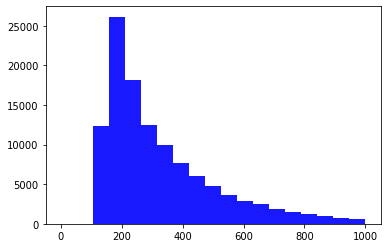

In [0]:
lens = [len(train_X[i]) for i in range(len(train_X))]
plt.hist(lens, bins=np.linspace(0,1000,20), facecolor='blue', alpha=0.9)
plt.show()

In [0]:
def prepare_data(train_x, train_y, tokenizer_char, tokenizer_word, maxlen_char, maxlen_word):
    x_tr, x_val, y_tr, y_val = train_test_split(train_x, train_y, test_size=0.1, random_state=1, stratify=train_y.values)

    train_X_char = tokenizer_char.texts_to_sequences(x_tr.sent)
    val_X_char = tokenizer_char.texts_to_sequences(x_val.sent)

    train_X_word = tokenizer_word.texts_to_sequences(x_tr.sent)
    val_X_word = tokenizer_word.texts_to_sequences(x_val.sent)

    ## Pad chars
    train_X_char = pad_sequences(train_X_char, maxlen=maxlen_char)
    val_X_char = pad_sequences(val_X_char, maxlen=maxlen_char)

    ## Pad words
    train_X_word = pad_sequences(train_X_word, maxlen=maxlen_word)
    val_X_word = pad_sequences(val_X_word, maxlen=maxlen_word)

    return ((train_X_char, train_X_word), y_tr), ((val_X_char, val_X_word), y_val)

In [0]:
filter_out = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n1234567890'

# for RNN use maxlen_char = 200
maxlen_char = 500
maxlen_word = 200

max_features_words = 64157
max_features_chars = 10489

## Tokenize words
tokenizer_words = Tokenizer(num_words=max_features_words, filters=filter_out, lower=True)  
tokenizer_words.fit_on_texts(x_train.sent)

## Tokenize chars
tokenizer_char = Tokenizer(num_words=max_features_chars, filters=filter_out, char_level=True)
tokenizer_char.fit_on_texts(x_train.sent)

In [0]:
((train_X_char, train_X_word), train_Y), ((val_X_char, val_X_word), val_Y) = prepare_data(x_train, y_train, tokenizer_char, tokenizer_words, maxlen_char, maxlen_word)

Ниже меняю представление векторов ответов из [1, 23, 10,...] в вектор длины 235 и с 1 на месте соответсвующего языка

In [85]:
lb = LabelEncoder()
y = lb.fit_transform(train_Y.values)
dummy_y_train = to_categorical(y)

print(len(dummy_y_train))
print(len(dummy_y_train[0]))

y = lb.fit_transform(val_Y.values)
dummy_y_val = to_categorical(y)

105750
235


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Model with two embeddings

In [0]:
embed_size = 20
def create_double_cnn():
    inp_char = Input(shape=(maxlen_char,))
    inp_word = Input(shape=(maxlen_word,))

    x1 = Embedding(max_features_chars, embed_size, input_shape=(maxlen_char,))(inp_char)
    x2 = Embedding(max_features_words, embed_size, input_shape=(maxlen_word,))(inp_word)

    concatted = tf.keras.layers.Concatenate(axis=1)([x1, x2])

    lay = Conv1D(256, 5, activation='relu')(concatted)
    lay = MaxPooling1D(5)(lay)
    lay = Dropout(0.2)(lay)

    lay = Conv1D(256, 5, activation='relu')(lay)
    lay = MaxPooling1D(5)(lay)
    lay = Flatten()(lay)

    lay = Dense(512, activation="relu")(lay)
    lay = Dropout(0.2)(lay)

    lay = Dense(num_classes, activation='softmax')(lay)
    return Model(inputs=[inp_char, inp_word], outputs=lay)

In [0]:
double_model = create_double_cnn()

In [89]:
double_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=train_metrics)
double_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 500, 20)      209780      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 200, 20)      1283140     input_2[0][0]                    
______________________________________________________________________________________________

In [0]:
double_cp_path = data_path+'model_double.hdf5'
double_cp=ModelCheckpoint(double_cp_path, monitor='val_loss',save_best_only=True)

In [91]:
double_model.fit([train_X_char, train_X_word], dummy_y_train, batch_size=512, epochs=5, 
              validation_data=([val_X_char, val_X_word], dummy_y_val),
               callbacks = [double_cp,  tf.keras.callbacks.TensorBoard(log_dir='./logs')]
                )

Epoch 1/5
207/207 [==============================] - 20s 94ms/step - loss: 3.0397 - categorical_accuracy: 0.3048 - precision_train: 0.5702 - recall_train: 0.1936 - f1_train: 0.2665 - val_loss: 0.9209 - val_categorical_accuracy: 0.7656 - val_precision_train: 0.9283 - val_recall_train: 0.6359 - val_f1_train: 0.7546
Epoch 2/5
207/207 [==============================] - 20s 96ms/step - loss: 0.6947 - categorical_accuracy: 0.8183 - precision_train: 0.9155 - recall_train: 0.7459 - f1_train: 0.8210 - val_loss: 0.4825 - val_categorical_accuracy: 0.8861 - val_precision_train: 0.9492 - val_recall_train: 0.8492 - val_f1_train: 0.8963
Epoch 3/5
207/207 [==============================] - 20s 97ms/step - loss: 0.3591 - categorical_accuracy: 0.9101 - precision_train: 0.9562 - recall_train: 0.8813 - f1_train: 0.9172 - val_loss: 0.4240 - val_categorical_accuracy: 0.9009 - val_precision_train: 0.9480 - val_recall_train: 0.8794 - val_f1_train: 0.9123
Epoch 4/5
207/207 [==============================] - 20

## Download model

In [0]:
double_model = load_model('./drive/My Drive/hackaton/model_cnn_double.hdf5', custom_objects=dependencies)

## Tensorboard

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

%load_ext tensorboard

In [0]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorboard.plugins import projector

In [0]:
# Set up a logs directory, so Tensorboard knows where to look for files
log_dir='./logs/imdb-example-chars3/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

siz = max_features_chars
ks = [tokenizer_char.index_word[i] for i in np.arange(1,siz)]
# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
  for subwords in tokenizer_char.word_docs.keys():
    f.write("{}\n".format(subwords))
  # Fill in the rest of the labels with "unknown"
  for unknown in range(1, max_features_chars - len(tokenizer_char.word_docs.keys())):
    f.write("unknown #{}\n".format(unknown))


# Save the weights we want to analyse as a variable. Note that the first
# value represents any unknown word, which is not in the metadata, so
# we will remove that value.
weights = tf.Variable(double_model.layers[2].get_weights()[0][1:siz])
# Create a checkpoint from embedding, the filename and key are
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [0]:
%tensorboard --logdir ./logs/imdb-example-chars3/

In [0]:
# Set up a logs directory, so Tensorboard knows where to look for files
log_dir='./logs/imdb-example-words/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately on a line-by-line manner.
#ks = list(tokenizer_words.index_word.values())[:20000]
siz = 40000
ks = [tokenizer_words.index_word[i] for i in np.arange(1,siz)]
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
  for subwords in ks:
    f.write("{}\n".format(subwords))
  # Fill in the rest of the labels with "unknown"
  for unknown in range(1, max_features_words - len(tokenizer_words.word_docs.keys())):
    f.write("unknown #{}\n".format(unknown))


# Save the weights we want to analyse as a variable. Note that the first
# value represents any unknown word, which is not in the metadata, so
# we will remove that value.
weights = tf.Variable(double_model.layers[3].get_weights()[0][1:siz])
# Create a checkpoint from embedding, the filename and key are
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [0]:
%tensorboard --logdir ./logs/imdb-example-words/

## RNN

In [0]:
embed_size = 200
def create_double_rnn():
    inp_char = Input(shape=(maxlen_char,))
    inp_word = Input(shape=(maxlen_word,))

    x1 = Embedding(max_features_chars, embed_size, input_shape=(maxlen_char,))(inp_char)
    x2 = Embedding(max_features_words, embed_size, input_shape=(maxlen_word,))(inp_word)

    concatted = tf.keras.layers.Concatenate(axis=1)([x1, x2])

    lay = Bidirectional(LSTM(150, return_sequences=True, activation='tanh',input_dim=embed_size))(concatted)
    lay = Dropout(0.2)(lay)

    lay = Bidirectional(LSTM(150, return_sequences=True, activation='tanh',input_dim=embed_size))(lay)
    lay = Dropout(0.2)(lay)
    lay = GlobalMaxPool1D()(lay)

    lay = Dense(512, activation="relu")(lay)
    lay = Dropout(0.2)(lay)

    lay = Dense(num_classes, activation='softmax')(lay)
    return Model(inputs=[inp_char, inp_word], outputs=lay)


In [0]:
double_rnn_model = create_double_rnn()
double_rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=train_metrics)
print(double_rnn_model.summary())

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 200, 200)     2097800     input_15[0][0]                   
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 200, 200)     12831400    input_16[0][0]                   
____________________________________________________________________________________________

In [0]:
double_rnn_cp_path = data_path+'model_rnn_double.hdf5'
double_rnn_cp=ModelCheckpoint(double_rnn_cp_path, monitor='val_loss',save_best_only=True)

In [0]:
double_rnn_model.fit([train_X_char, train_X_word], dummy_y_train, batch_size=512, epochs=7, 
              validation_data=([val_X_char, val_X_word], dummy_y_val),
               callbacks = [double_cp]
             )

Epoch 1/7
207/207 [==============================] - 327s 2s/step - loss: 2.8170 - categorical_accuracy: 0.3641 - f1_met: 0.2020 - precision: 0.6202 - recall: 0.2168 - val_loss: 0.8080 - val_categorical_accuracy: 0.8463 - val_f1_met: 0.6258 - val_precision: 0.9715 - val_recall: 0.6720
Epoch 2/7
207/207 [==============================] - 323s 2s/step - loss: 0.4632 - categorical_accuracy: 0.8946 - f1_met: 0.7694 - precision: 0.9495 - recall: 0.8552 - val_loss: 0.4192 - val_categorical_accuracy: 0.9133 - val_f1_met: 0.7912 - val_precision: 0.9708 - val_recall: 0.8726
Epoch 3/7
207/207 [==============================] - 324s 2s/step - loss: 0.2131 - categorical_accuracy: 0.9511 - f1_met: 0.8366 - precision: 0.9747 - recall: 0.9379 - val_loss: 0.3645 - val_categorical_accuracy: 0.9203 - val_f1_met: 0.8071 - val_precision: 0.9627 - val_recall: 0.8990
Epoch 4/7
207/207 [==============================] - 322s 2s/step - loss: 0.1271 - categorical_accuracy: 0.9697 - f1_met: 0.8565 - precision: 

KeyboardInterrupt: ignored

## Results

In [0]:
x_test['sc'] = y_test
x_test['lang'] = [class_to_language[y] for y in list(y_test.iloc[:,0])]
x_train['sc'] = y_train
x_train['lang'] = [class_to_language[y] for y in list(y_train.iloc[:,0])]

In [0]:
def convert(x, tokenizer_char, tokenizer_word, maxlen_char, maxlen_word):
    X_char = tokenizer_char.texts_to_sequences(x.sent)
    X_word = tokenizer_word.texts_to_sequences(x.sent)

    ## Pad chars
    X_char = pad_sequences(X_char, maxlen=maxlen_char)

    ## Pad words
    X_word = pad_sequences(X_word, maxlen=maxlen_word)

    return (X_char, X_word)

## Test

In [0]:
x_char, x_word = convert(x_test, tokenizer_char, tokenizer_words, maxlen_char, maxlen_word)

In [0]:
y = lb.fit_transform(y_test.values)
dummy_y_test = to_categorical(y)

In [0]:
y_pred_rnn = double_rnn_model.predict([x_char, x_word])

In [0]:
p, r, f = met(dummy_y_test, y_pred_rnn)
raw_metrics_rnn = pd.DataFrame(
    {'precision': p,
     'recall': r,
     'f1': f
    })
metrics_rnn = raw_metrics_rnn.rename(class_to_language, axis='index')

In [0]:
y_pred_cnn = double_model.predict([x_char, x_word])

In [0]:
p, r, f = met(dummy_y_test, y_pred_cnn)
raw_metrics_cnn = pd.DataFrame(
    {'precision': p,
     'recall': r,
     'f1': f
    })
metrics_cnn = raw_metrics_cnn.rename(class_to_language, axis='index')

In [0]:
metrics_rnn[metrics_rnn.f1 < 0.8]

,precision,recall,f1
be-tarask,0.841379,0.732,0.782888
bos,0.629747,0.398,0.487745
cbk,0.881868,0.642,0.743056
deu,0.876513,0.724,0.792990
eng,0.672000,0.336,0.448000
fra,0.863415,0.708,0.778022
hbs,0.489458,0.650,0.558419
hrv,0.648148,0.420,0.509709
ind,0.857471,0.746,0.797861
map-bms,0.959302,0.660,0.781991


In [0]:
metrics_rnn[metrics_rnn.f1 > 0.95].shape

(116, 3)

In [0]:
metrics_cnn[metrics_cnn.f1 < 0.7]

,precision,recall,f1
bos,0.551402,0.590,0.570048
eng,0.607921,0.614,0.610945
hbs,0.566667,0.374,0.450602
hrv,0.545692,0.418,0.473386


In [0]:
metrics_cnn[metrics_cnn.f1 > 0.95].shape

(120, 3)

# Handy example

In [0]:
my = pd.DataFrame(
    {'sent': ['English is a West Germanic language that was first spoken in early medieval England and eventually became a global lingua franca.[4][5] It is named after the Angles, one of the ancient Germanic peoples that migrated to the area of Great Britain that later took their name, England. Both names derive from Anglia, ',
              'язык англо-фризской подгруппы западной группы германской ветви индоевропейской языковой семьи. Английский язык — важнейший международный язык[4], что является следствием колониальной политики Британской империи в XIX веке и мирового влияния США в XX—XXI веках. Существует значительное разнообразие диалектов и говоров английского языка.',
              'Produkcja aparatów fotograficznych w kijowskich zakładach Arsenal rozpoczęła się od przeniesienia w 1946 r. z Drezna całej, ledwie uruchomionej po zniszczeniach wojennych linii produkcyjnej aparatów małoobrazkowych Contax, wraz z zatrudnionymi przy niej fachowcami. ',
              'З 1944 года дзейнічае Дзяржаўны літаратурны музей Янкі Купалы. У гонар паэта ў 1957 годзе была заснавана Літаратурная прэмія імя Янкі Купалы. З 1995 года сістэматычна праводзяцца штогадовыя Купалаўскія чытанні — прафесійны форум для абмеркавання навуковых дасягненняў і праблем купалазнаўства.'
              ],
    })

In [0]:
x_char, x_word = convert(my, tokenizer_char, tokenizer_words, maxlen_char, maxlen_word)

In [0]:
ys = double_model.predict([x_char, x_word])
ys.argmax(axis=1)

array([ 50, 177, 168,  18])

In [0]:
ys = double_rnn_model.predict([x_char, x_word])
ys.argmax(axis=1)

array([ 50,  10, 168,  18])

In [0]:
class_to_language[10]

'ava'

In [0]:
class_to_language[228]

'xho'

In [0]:
class_to_language[50]

'eng'

In [0]:
class_to_language[177]

'rus'

In [0]:
class_to_language[168]

'pol'

In [0]:
class_to_language[18]

'bel'